<a href="https://colab.research.google.com/github/ptkeens/cs5262-data-science-project/blob/eda/neo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluating the Danger of Near Earth Orbit Asteroids

## Background
Asteroids are the rocky remnants of material leftover from the solar system's formation, and are generally found in our solar system's "main belt", located between Mars and Jupitter. <sub>1</sub>. The current known asteroid count is 1,302,459, the vast majority of which orbit in the main asteroid belt. <sub>1</sub>. Asteroids are generally classified into 3 categories: Main Belt, Trojan, and Near-Earth <sub>1</sub>.

## Project Description
This project will focus on Near-Earth Objects (NEO). These objects are defined as "potentially hazardous" when its minimum orbit intersection distance is &lt;0.05 AU (4,647,790 mi) and it has an absolute magnitude of H&lt;22 (i.e. mean diameter > 140 m)<sub>2</sub>. Given that we are evaluating space-bound objects, it is important to remember that many of these values are given in a range format, or are an estimation based on available data sources. The data has been gathered in a kaggle dataset, which was sourced from the NASA NEO Earth Close Approaches API (https://cneos.jpl.nasa.gov/ca/).

## Performance Metrics
In this project, we have a set of 27,423 unique NEO objects with accompanying attribute data such as estimated diameter, relative velocity (to Earth at close approach), the distance by which it misses the Earth, its absolute magnitude, and whether or not it is considered "hazardous".

The goal of this project will be to clean the data to ensure it obeys the defined rules for an object being considered hazardous, and to then use this data as a training set for a machine-learning model to evaluate the boolean condition of if an NEO is considered hazardous. The exact mathematical expressions that will be used will be discovered as we progress through the course.

## Data Sources
This project is using data from a kaggle dataset, found [here](https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects)

1 Nasa (2021, July 19). *Asteroids*. https://solarsystem.nasa.gov/asteroids-comets-and-meteors/asteroids/in-depth/

2 Perna, D., Barucci, M.A, Fulchignoni, M (2013). "The near-Earth objects and their potential threat to our planet". *The Astronomy and astrophysics review*, 21(1), 1-28

## Setting Up

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

### Loading The Data

In [69]:
raw = pd.read_csv('neo_v2.csv')
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


### Take a look at a random sampling of data

Lets examine 10 random rows from the dataset to get a feel for the data

In [70]:
raw.sample(10)

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
24625,3388355,(2007 TE66),0.128990,0.288430,25878.988032,3.853268e+07,Earth,False,21.57,False
70891,54100624,(2020 YH),0.101054,0.225964,58862.603126,3.356753e+07,Earth,False,22.10,False
33309,3837547,(2019 AL),0.096506,0.215794,58751.373215,4.038390e+07,Earth,False,22.20,False
39787,3607823,(2012 QL14),0.035039,0.078350,47889.745183,1.603870e+07,Earth,False,24.40,False
13337,3277570,(2005 JU1),0.127220,0.284472,61403.801946,7.171831e+06,Earth,False,21.60,True
53767,3725122,(2015 OR78),0.106796,0.238803,11645.694132,3.762360e+07,Earth,False,21.98,False
32154,3869325,(2019 SR5),0.076658,0.171412,42568.622304,1.738053e+07,Earth,False,22.70,False
25531,54017044,(2020 KA),0.008405,0.018795,57255.996858,5.146244e+07,Earth,False,27.50,False
34947,2304293,304293 (2006 SQ78),0.472667,1.056915,81257.893505,7.030515e+07,Earth,False,18.75,False
57659,54138303,(2021 GT16),0.008801,0.019681,27940.998942,2.292015e+06,Earth,False,27.40,False


### Examine how many unique asteroid IDs we have

This dataset contains information about many passes, the original data source says we should have 27,423 unique NEOs

In [71]:
len(raw.groupby('id'))

27423

### Prune some data we don't want for our model & analysis

We don't need/want the `id`, `name`, `orbiting_body` or `sentry_object` columns. These offer nothing we need in our analysis/model fitting.

In [72]:
refined = raw.drop(['id', 'name', 'orbiting_body', 'sentry_object'], axis=1)
refined


,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,False
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,True
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,False
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,False
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,True
...,...,...,...,...,...,...
90831,0.026580,0.059435,52078.886692,1.230039e+07,25.00,False
90832,0.016771,0.037501,46114.605073,5.432121e+07,26.00,False
90833,0.031956,0.071456,7566.807732,2.840077e+07,24.60,False
90834,0.007321,0.016370,69199.154484,6.869206e+07,27.80,False


## Questions to Answer
The fundamental questions that I would like to explore are:
1.   Is the data set balanced? Logic would dictate that we would have more events that are non-hazardous than hazardous. How can we solve for this problem so as not to unduly influence our ML model?
2.   What kind of correlation is there between the magnitude of an object and its diameter?
3.   Do we have any outliers that we need to clean out of the data set so as not to influence the model?
4.   Is the data that we have already correctly predicting whether or not an object is hazardous? Do we need to correct any data?



## Balancing Our Dataset

### Distribution of hazardous value
Knowing that most asteroids are not hazardous to the Earth, I suspect that our data set is imbalanced. What is the ratio of hazardous to non-hazardous events in our data set? Are we imbalanced, and if so, how badly?

([<matplotlib.patches.Wedge at 0x79bb388a7430>,
 [Text(-1.0489888280748159, 0.33109279450665313, 'False'),
  Text(1.0489888435743868, -0.3310927453999418, 'True')])

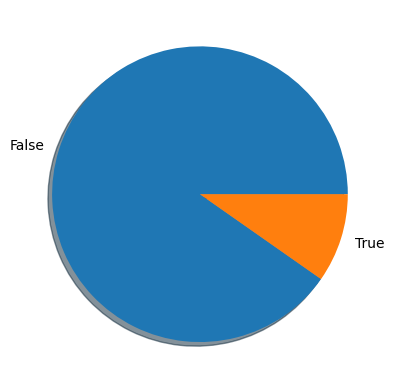

In [73]:
hazardous_values = refined['hazardous'].value_counts()
plt.pie(hazardous_values, labels=hazardous_values.index, shadow = True)

### Examine our raw counts for each class
We can cleary see a heavy imbalance towards non-hazardous asteroids!

In [74]:
print(hazardous_values)

# assign the count to a variable for use below
maximum_class_size = hazardous_values[True]

False    81996
True      8840
Name: hazardous, dtype: int64


### Create a balanced version of our data set for analysis
We have 2 classes of data (hazardous, non-hazardous), and we need to undersample our majority class (non-hazardous) so we can have a data frame that is more balanced for use in our model.

In [75]:
# Define our majority and minority class by selecting hazardous into one frame, and non-hazardous into another
df_majority = refined[refined['hazardous'] == 0]
df_minority = refined[refined['hazardous'] == 1]

# Resample the classes with the size of the minority class as the max
majority_class = resample(df_majority, replace=False, n_samples=maximum_class_size, random_state=0)
minority_class = resample(df_minority, replace=True, n_samples=maximum_class_size, random_state=0)

# Combine them into a new data frame
balanced = pd.concat([majority_class, minority_class])

# Examine the split of our new data frame
balanced['hazardous'].value_counts()


False    8840
True     8840
Name: hazardous, dtype: int64

## Data Analysis

### High-Level analytical data points


In [76]:
balanced.describe()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,17680.000000,17680.000000,17680.000000,1.768000e+04,17680.000000
mean,0.204546,0.457379,54851.722474,3.833882e+07,22.076150
std,0.286652,0.640974,27351.387442,2.197866e+07,2.844841
min,0.000818,0.001828,963.192079,1.789684e+04,12.440000
25%,0.040230,0.089958,34026.085222,1.924629e+07,20.200000
50%,0.138215,0.309058,51026.658800,3.926564e+07,21.420000
75%,0.242412,0.542051,70489.865657,5.759446e+07,24.100000
max,8.640820,19.321462,193386.975218,7.479095e+07,32.560000


### Explore the data in our balanced data frame
Let's take a look at a pairplot for our balanced dataframe and see what we can observe by viewing some graphs

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


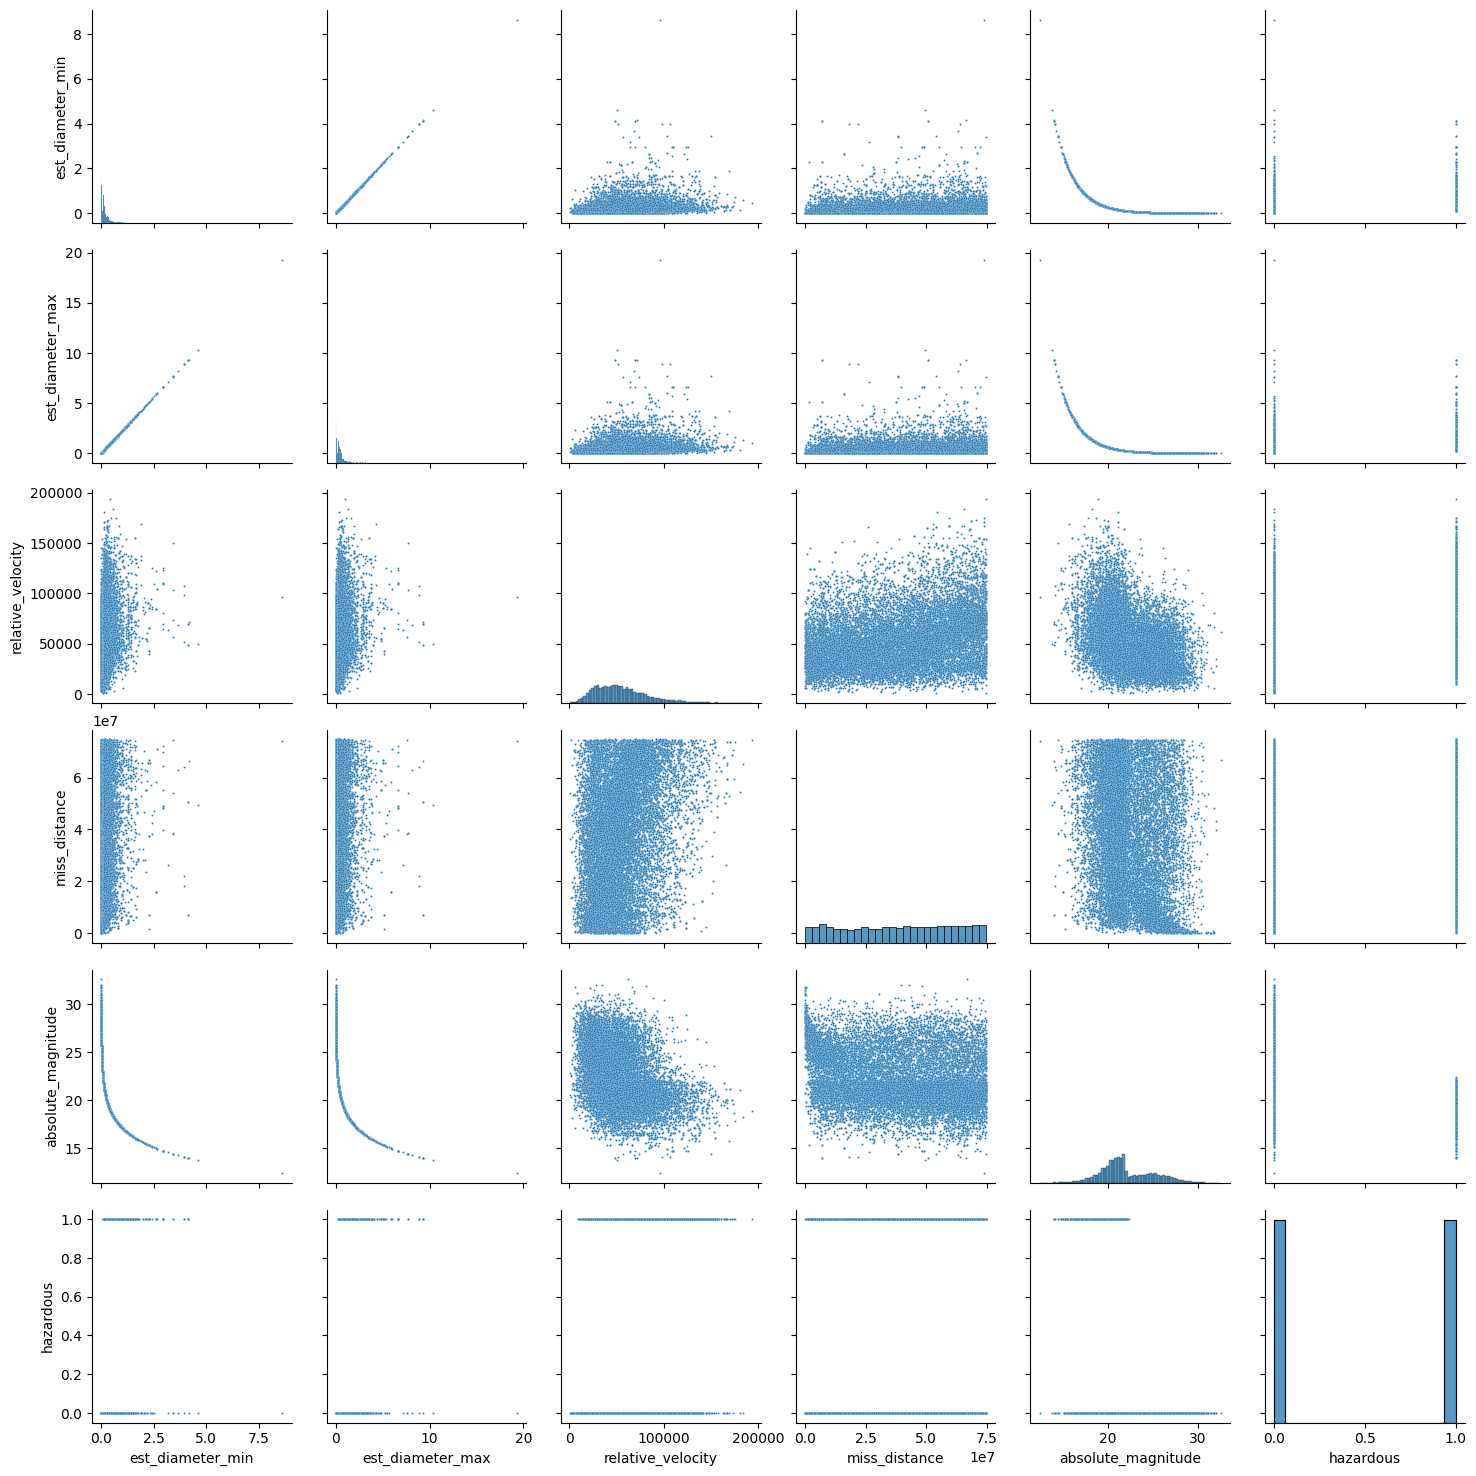

In [80]:
sns.pairplot(balanced, plot_kws={'s': 2})

### Observations from the pair plot & describe() output
1. We can see a linear correlation between `est_diamter_min` and `est_diameter_max`, but this is not useful data. We do not need both of these values, we can instead create a new feature `est_diameter_avg` and use this for diameter.
2. We have some outliers that could be cleaned up via clipping or removing the data, as observed in the Outliers section below.
3. There is a very clear curve that is created when comparing diameter and magnitude, which is one of the items I was curious about! We will explore this below.

### Cleaning up our diameter measurements
Let's create a new feature: `est_diameter_avg` which will take the average of `est_diamter_min` and `est_diameter_max`. This will allow us to trim those 2 columns from our data frame and keep a single value for use in comparisons.

In [124]:
# Copy our frame to alter it
balanced_copy = balanced.copy()

# Create a new feature to represnt the average
balanced_copy['est_diameter_avg'] = (balanced_copy['est_diameter_min'] + balanced_copy['est_diameter_max']) / 2

# Drop the old 2 columns
balanced_with_one_diameter = balanced_copy.drop(['est_diameter_min', 'est_diameter_max'], axis=1)

# Describe the new data frame
balanced_with_one_diameter.describe()

,relative_velocity,miss_distance,absolute_magnitude,est_diameter_avg
count,17680.000000,1.768000e+04,17680.000000,17680.000000
mean,54851.722474,3.833882e+07,22.076150,0.330962
std,27351.387442,2.197866e+07,2.844841,0.463813
min,963.192079,1.789684e+04,12.440000,0.001323
25%,34026.085222,1.924629e+07,20.200000,0.065094
50%,51026.658800,3.926564e+07,21.420000,0.223636
75%,70489.865657,5.759446e+07,24.100000,0.392232
max,193386.975218,7.479095e+07,32.560000,13.981141


### Outliers
By examining some standard analytical data points, we can see that we do have some outlier data. The max column for `est_diameter_min`, `est_diameter_max`, and `relative_velocity` show some values that are quite high when compared to the rest. We can visualize this better in some independent graphs

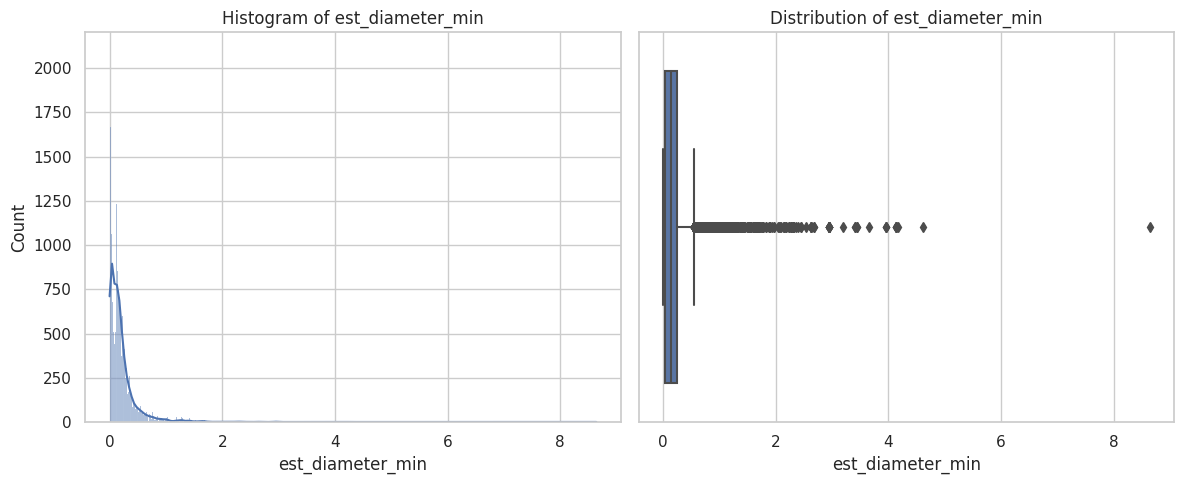

In [160]:
# Create a function to produce our visualizations so we don't repeat this 3x
def create_distribution_plot(data, column_name):
    # Set the style for the plot (optional)
    sns.set(style="whitegrid")

    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Plot a histogram on the left subplot
    sns.histplot(data=data, x=column_name, kde=True, ax=axes[0])
    axes[0].set_title(f'Histogram of {column_name}')

    # Plot a distribution (box plot) on the right subplot
    sns.boxplot(data=data, x=column_name)
    axes[1].set_title(f'Distribution of {column_name}')

    # Adjust plot layout
    plt.tight_layout()

    # Show the plot
    plt.show()

# Visualize `est_diameter_min`
create_distribution_plot(balanced, "est_diameter_min")

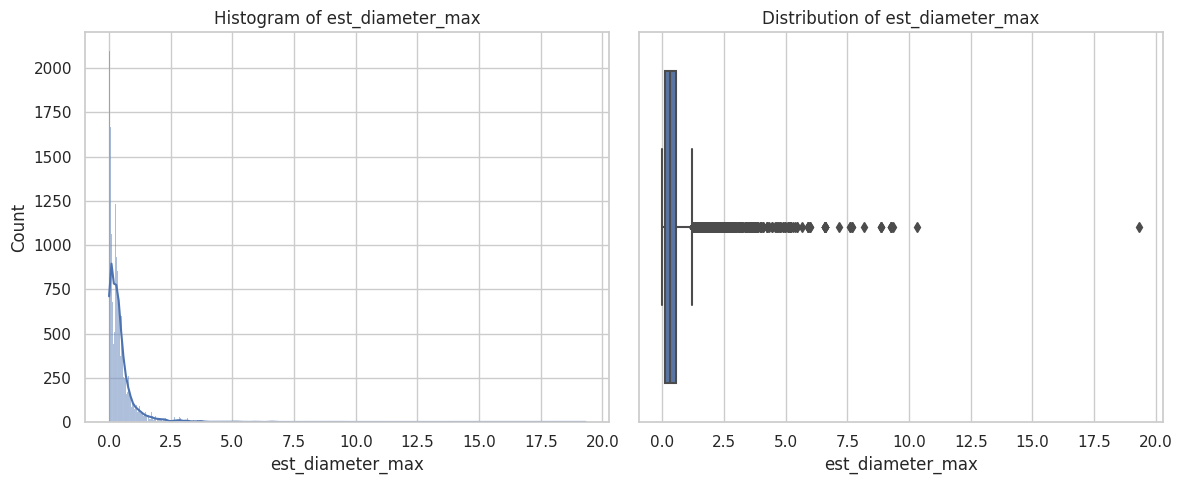

In [161]:
# Visualize `est_diameter_max`
create_distribution_plot(balanced, 'est_diameter_max')

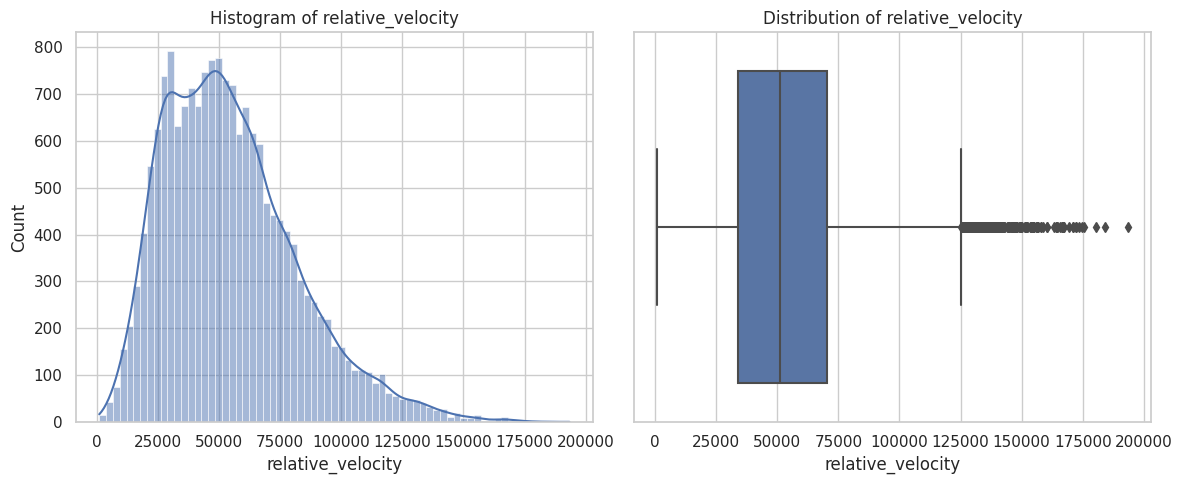

In [162]:
# visualize `relative_velocity`
create_distribution_plot(balanced, 'relative_velocity')

### Remove Outliers
Take a closer look at removing our outliers. As we saw from the distributions, we have some very extreme outliers. Because of this, we probably want to avoid using a mean-based deviation approach to detecting outliers (which would be sensitive to extreme outliers), and instead use Inter-Quartile Range.


Interquartile Range for relative_velocity: 36463.78043498438
Upper bound for relative_velocity: 125185.53630932394
Total rows identified as outliers for relative_velocity: 327


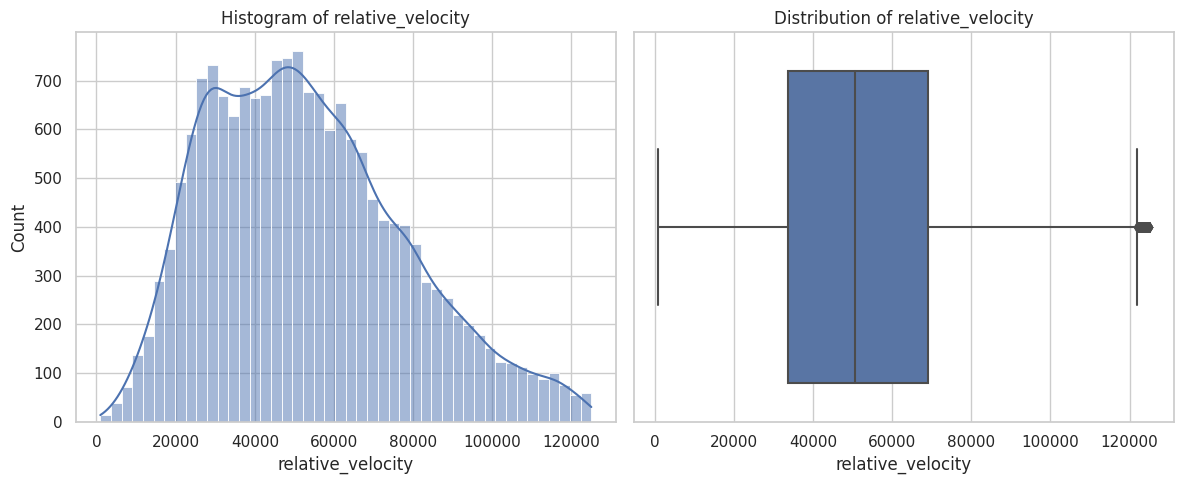

In [182]:
# Create a function we can re-use to prune outliers
def remove_outliers(data, column, iqr_fold=1.5):
  # create a copy of the data frame on which to apply the mask
  data_copy = data.copy()

  # Get the IQR
  iqr = data[column].quantile(0.75) - data[column].quantile(0.25)
  print(f"Interquartile Range for {column}: {iqr}")

  # Determine our upper bound
  upper_bound = data[column].quantile(0.75) + (iqr * iqr_fold)
  print(f"Upper bound for {column}: {upper_bound}")

  # Create a mask to reduce our data set
  outlier_mask = data[column] > upper_bound
  outlier_count = outlier_mask.sum()
  print(f"Total rows identified as outliers for {column}: {outlier_count}")

  # Return the reduced data in a new data frame
  return data_copy[~outlier_mask]

# Create a data frame by applying the mask
relative_velocity_pruned_data = remove_outliers(balanced_with_one_diameter, 'relative_velocity', 1.5)

# Examine the same metric now!
create_distribution_plot(relative_velocity_pruned_data, 'relative_velocity')

We also need to remove outliers from `est_diameter_avg`


Interquartile Range for est_diameter_avg: 0.32468548935
Upper bound for est_diameter_avg: 0.873878247975
Total rows identified as outliers for est_diameter_avg: 1177


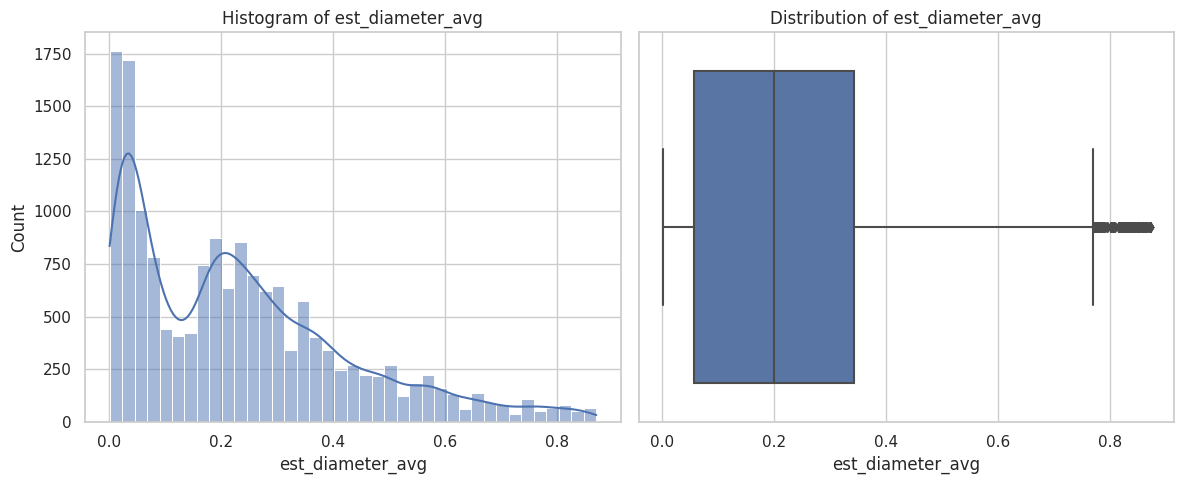

In [183]:
est_diameter_avg_pruned_data = remove_outliers(relative_velocity_pruned_data, 'est_diameter_avg', 1.5)
create_distribution_plot(est_diameter_avg_pruned_data, 'est_diameter_avg')

Check our data balance now that we have pruned some data. We want to ensure that we are not removing large amounts of rows from one class only. We can see a slight decrease in the amount of hazardous rows, but still quite close to being equal.

False    8486
True     7690
Name: hazardous, dtype: int64


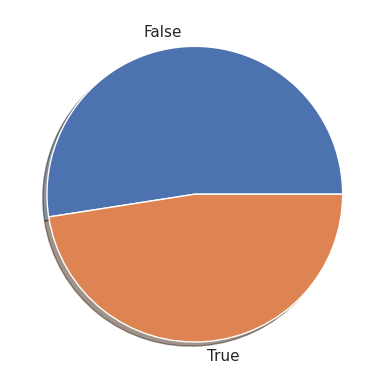

In [184]:
hazardous_values = est_diameter_avg_pruned_data['hazardous'].value_counts()
plt.pie(hazardous_values, labels=hazardous_values.index, shadow = True)
print(hazardous_values)

### Re-examine data after changes
The only clear relationship I see in this data is that of absolute magnitude and estimated diameter.

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


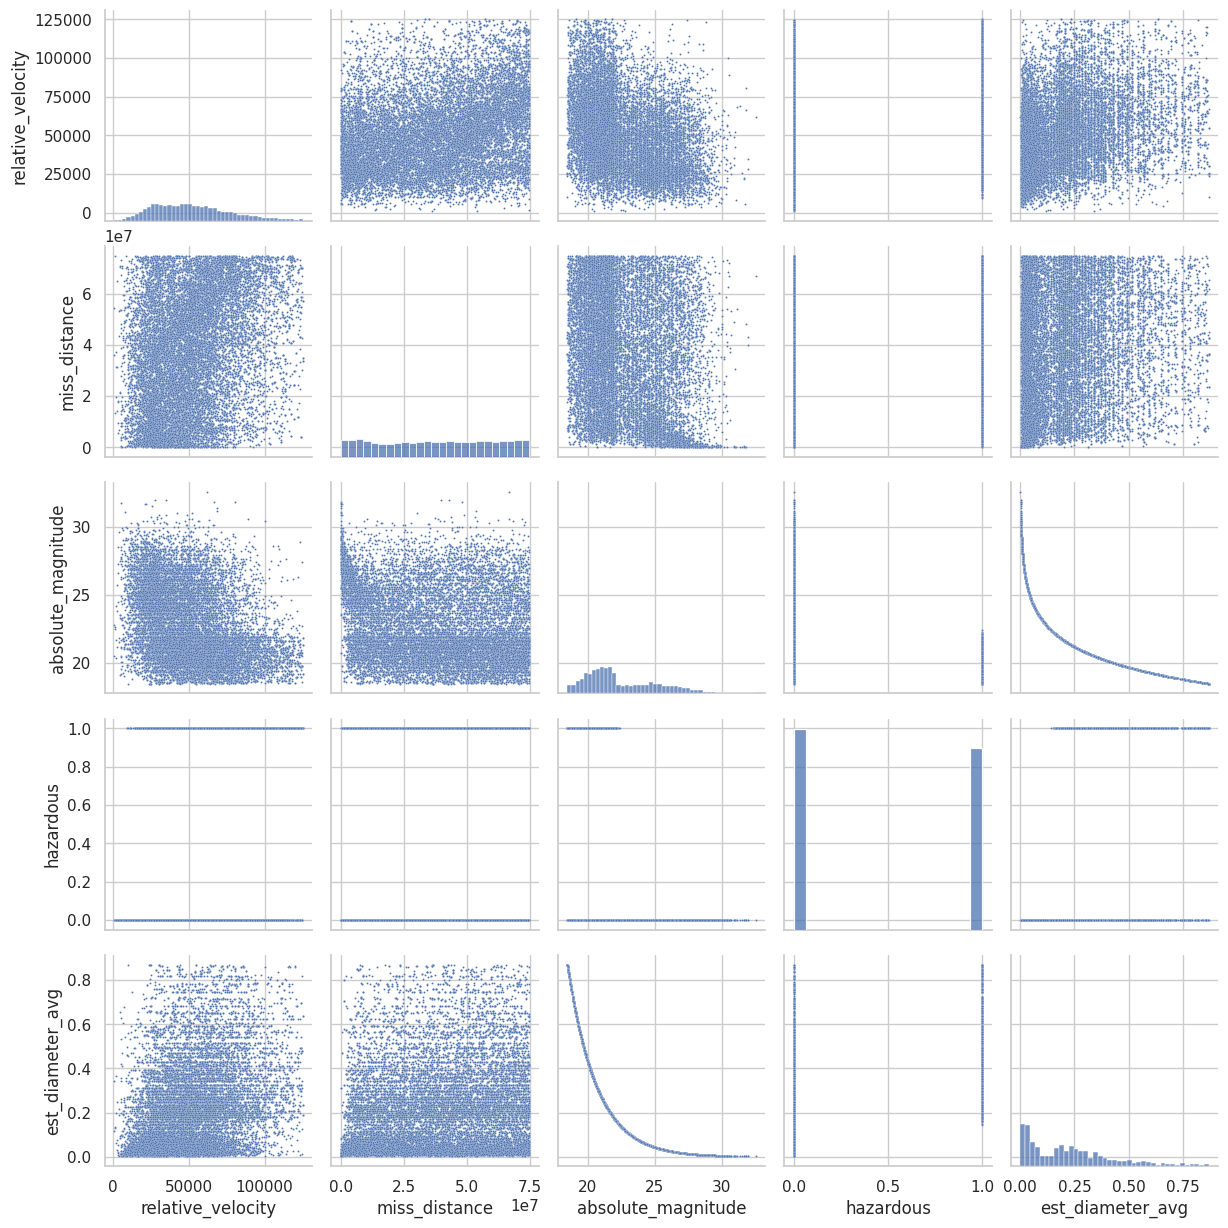

In [186]:
sns.pairplot(est_diameter_avg_pruned_data, plot_kws={'s': 2})

### Relationship between estimated diameter and magnitude
One observation above was that there is a clear relationship between the diameter and the magnitude of an object. If we think about what this is saying, it makes sense.

In astronomy, magnitude is a measurement of brightness of an object as observed from Earth. The magnitude scale is logarithmic, so each whole number increase on the scale represents a *decrease* in brightness by a factor of approximately 2.5. So what we are seeing is a curve displaying exactly that - as the magnitude goes up, the estimated diameter decreases (because a higher absolute magnitude represents a smaller amount of light).


## Train Test Split
